### **Q6: Kaggle - Taxi Fare Prediction**

#### **Basic Intuition about how taxi fares vary in New York (or in general)**
1. Fares highly depend on weather (fall, autumn), time of the day (peak hours of the day or not), etc.
2. Fares can be very less in case some coupon/discount is applied by the customer.
3. Fares also vary depending on the distance and the waiting time due to traffic or any other reason.
4. Fares also vary if there is a surge in fuel prices.

_*Keeping these pointers in mind, let's analyse the data and see what information related to any of the above mentioned factors can be extracted to prepare a better dataset.*_

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import cos, sin, arcsin, sqrt
from math import radians
import matplotlib.pyplot as plt
from collections import Counter

random.seed(999)
np.random.seed(999)

In [27]:
# train, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')
# train.sample(10000000, random_state=999).to_csv('train_sub.csv') 

# This was done to avoid loading the whole dataset again and again. Was very time taking.

### **Training the model for 10M data points randomly sampled from the given dataset.**

In [2]:
# train_sub is the subset of original data containing 10M data points.
train, test = pd.read_csv('train_sub.csv'), pd.read_csv('test.csv')

In [3]:
train.shape, test.shape

((10000000, 8), (9914, 7))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 610.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,1.130970e+01,-7.397511e+01,4.075111e+01,-7.397427e+01,4.075147e+01,1.685310e+00
std,9.619489e+00,3.823555e-02,2.939274e-02,3.732375e-02,3.261382e-02,1.313272e+00
min,-9.500000e+01,-7.426300e+01,4.056900e+01,-7.426300e+01,4.056900e+01,0.000000e+00
25%,6.000000e+00,-7.399200e+01,4.073700e+01,-7.399200e+01,4.073600e+01,1.000000e+00
50%,8.500000e+00,-7.398200e+01,4.075300e+01,-7.398100e+01,4.075400e+01,1.000000e+00
75%,1.250000e+01,-7.396800e+01,4.076800e+01,-7.396500e+01,4.076800e+01,2.000000e+00
max,9.000000e+02,-7.299300e+01,4.170600e+01,-7.298800e+01,4.170600e+01,2.080000e+02


In [7]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [8]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00 UTC,-73.777,40.645,-73.984,40.757,1
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00 UTC,-74.002,40.730,-73.992,40.725,2
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00 UTC,-73.995,40.726,-74.011,40.729,1
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30 UTC,-73.978,40.746,-74.010,40.721,1
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59 UTC,-74.004,40.720,-74.015,40.709,1


In [9]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [10]:
print(train.shape)
print('Before Drop:\n',train.isna().sum(), end='\n\n')

(10000000, 8)
Before Drop:
 key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64



In [11]:
train.dropna(inplace=True)
print('After Drop:\n',train.isna().sum())
print(train.shape)

After Drop:
 key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
(10000000, 8)


In [12]:
print(test.shape)
print('Before Drop:\n',test.isna().sum(), end='\n\n')

(9914, 7)
Before Drop:
 key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64



In [13]:
train.shape, test.shape

((10000000, 8), (9914, 7))

### **Finding and removing the data points with pickup/dropoff lat/long to be equal to zero.**

In [14]:
train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

(0, 8)

In [15]:
rows = train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)]

In [16]:
train.drop(rows.index, axis=0, inplace=True)

In [17]:
train.shape

(10000000, 8)

### **Rounding off the lat and long values for the model to find some patterns in the data.**

In [18]:
train.pickup_latitude = train.pickup_latitude.round(3)
train.pickup_longitude = train.pickup_longitude.round(3)  
train.dropoff_latitude = train.dropoff_latitude.round(3)  
train.dropoff_longitude = train.dropoff_longitude.round(3)

In [19]:
test.pickup_latitude = test.pickup_latitude.round(3)
test.pickup_longitude = test.pickup_longitude.round(3)  
test.dropoff_latitude = test.dropoff_latitude.round(3)  
test.dropoff_longitude = test.dropoff_longitude.round(3)

In [20]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00 UTC,-73.777,40.645,-73.984,40.757,1
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00 UTC,-74.002,40.730,-73.992,40.725,2
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00 UTC,-73.995,40.726,-74.011,40.729,1
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30 UTC,-73.978,40.746,-74.010,40.721,1
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59 UTC,-74.004,40.720,-74.015,40.709,1


In [21]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973,40.764,-73.981,40.744,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.987,40.719,-73.999,40.739,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.983,40.751,-73.980,40.746,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981,40.768,-73.990,40.752,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966,40.790,-73.989,40.744,1


### **Finding out the proper bounds for lat and long values for removing outliers.**
<span style='color:blue'>New York's latitude and longitude: 40.7128° N, 74.0060° W
And so the below mentioned ranges clearly show the presence of outliers as lat and long values cannot go this large or vary to this extent for a city.</span>

In [24]:
train.pickup_latitude.min(), train.pickup_latitude.max(), train.pickup_longitude.min(), train.pickup_longitude.max()

(40.569, 41.706, -74.263, -72.993)

In [25]:
test.pickup_latitude.min(), test.pickup_latitude.max(), test.pickup_longitude.min(), test.pickup_longitude.max()

(40.573, 41.71, -74.252, -72.987)

In [26]:
train.dropoff_latitude.min(), train.dropoff_latitude.max(), train.dropoff_longitude.min(), train.dropoff_longitude.max()

(40.569, 41.706, -74.263, -72.988)

In [27]:
test.dropoff_latitude.min(), test.dropoff_latitude.max(), test.dropoff_longitude.min(), test.dropoff_longitude.max()

(40.569, 41.697, -74.263, -72.991)

### **Fixing the upper and lower bounds to remove outliers.**

In [28]:
lat_min, lat_max, long_min, long_max = 40.569, 41.71, -74.263, -72.987

#### **In the saved csv file of subset of dataset, this preprocessing of rounding off and removing outside lower and upper bounds had been done already and hence below code is commented out.**

In [44]:
# train.pickup_latitude = train.pickup_latitude[train.pickup_latitude.between(left=lat_min, right=lat_max)]
# train.dropoff_latitude = train.dropoff_latitude[train.dropoff_latitude.between(left=lat_min, right=lat_max)]
# train.pickup_longitude = train.pickup_longitude[train.pickup_longitude.between(left=long_min, right=long_max)]
# train.dropoff_longitude = train.dropoff_longitude[train.dropoff_longitude.between(left=long_min, right=long_max)]

In [29]:
train.pickup_latitude.min(), train.pickup_latitude.max(), train.pickup_longitude.min(), train.pickup_longitude.max()

(40.569, 41.706, -74.263, -72.993)

In [30]:
train.dropoff_latitude.min(), train.dropoff_latitude.max(), train.dropoff_longitude.min(), train.dropoff_longitude.max()

(40.569, 41.706, -74.263, -72.988)

In [31]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00 UTC,-73.777,40.645,-73.984,40.757,1
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00 UTC,-74.002,40.730,-73.992,40.725,2
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00 UTC,-73.995,40.726,-74.011,40.729,1
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30 UTC,-73.978,40.746,-74.010,40.721,1
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59 UTC,-74.004,40.720,-74.015,40.709,1


In [32]:
train.shape
train.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [53]:
# Uncomment when using the original data or sample extracted from it
# train.dropna(inplace=True)
# train.isna().sum()

In [33]:
# train.head()

In [34]:
# test.head()

In [35]:
new_train = train

#### **General Facts about data**
1. As key contains unique values, so it does not hold any value in training the model.
2. pickup_datetime contains condensed information about year, months, days and hour of the day and hence it can be segregated to create new features to enhance the richness of the data.
3. Distance is not given but using the longitudes and latitude values, we can find out the distance using Haversine Formula.
4. passenger_count also affects the taxi fares and hence is an important feature and can be used directly.
5. Feature Engineering is required to collect more features:</br>
    5a. For calculating distance,</br>
    5b. For creating features for year, month, week, weekday, day, and hour.
    
### **Finding the Haversine distance using Haversine formula.**
This distance is chosen as this distance is more relevant to find distance between two points when given in terms of latitude and longitude values. Values are rounded off with a notion to help the model find patterns in the data as more decimel places may result in different values even for a minute change.

In [36]:
def get_distance(record):
    src_longtitude, src_latitude, dest_longtitude, dest_latitude = tuple(record.values.tolist()) 
    src_longtitude, src_latitude, dest_longtitude, dest_latitude = map(radians, [src_longtitude, src_latitude, dest_longtitude, dest_latitude])
    longtitude_diff = dest_longtitude - src_longtitude 
    latitude_diff = dest_latitude - src_latitude
    # Haversine Formula
    a = sin(latitude_diff/2)**2 + cos(src_latitude) * cos(dest_latitude) * sin(longtitude_diff/2)**2
    c = 2*arcsin(sqrt(a))
    # Radius of Earth: 6371 KM
    distance = 6371*c
    return distance

new_train['distance'] = new_train.iloc[:, 3:7].apply(get_distance, axis=1).round(3)
test['distance'] = test.iloc[:, 2:6].apply(get_distance, axis=1).round(3)

In [37]:
new_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00 UTC,-73.777,40.645,-73.984,40.757,1,21.438
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00 UTC,-74.002,40.730,-73.992,40.725,2,1.010
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00 UTC,-73.995,40.726,-74.011,40.729,1,1.389
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30 UTC,-73.978,40.746,-74.010,40.721,1,3.873
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59 UTC,-74.004,40.720,-74.015,40.709,1,1.535


In [38]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973,40.764,-73.981,40.744,1,2.324
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.987,40.719,-73.999,40.739,1,2.443
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.983,40.751,-73.980,40.746,1,0.611
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981,40.768,-73.990,40.752,1,1.934
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966,40.790,-73.989,40.744,1,5.469


In [39]:
new_train.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
dtype: int64

In [40]:
new_train.pickup_datetime = pd.to_datetime(new_train.pickup_datetime)
test.pickup_datetime = pd.to_datetime(test.pickup_datetime)

In [41]:
new_train.pickup_datetime.dtype, test.pickup_datetime.dtype

(datetime64[ns, UTC], datetime64[ns, UTC])

In [42]:
new_train['year'] = new_train.pickup_datetime.dt.year
new_train['month'] = new_train.pickup_datetime.dt.month
new_train['week'] = new_train.pickup_datetime.dt.week
new_train['weekday'] = new_train.pickup_datetime.dt.weekday
new_train['day'] = new_train.pickup_datetime.dt.day
new_train['hour'] = new_train.pickup_datetime.dt.hour

In [43]:
test['year'] = test.pickup_datetime.dt.year
test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['day'] = test.pickup_datetime.dt.day
test['hour'] = test.pickup_datetime.dt.hour

In [44]:
new_train.shape, test.shape

((10000000, 15), (9914, 14))

In [45]:
new_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00+00:00,-73.777,40.645,-73.984,40.757,1,21.438,2014,1,4,5,25,23
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00+00:00,-74.002,40.730,-73.992,40.725,2,1.010,2012,1,2,6,15,18
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00+00:00,-73.995,40.726,-74.011,40.729,1,1.389,2013,12,51,1,17,15
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30+00:00,-73.978,40.746,-74.010,40.721,1,3.873,2009,6,26,4,26,5
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59+00:00,-74.004,40.720,-74.015,40.709,1,1.535,2012,7,30,5,28,2


In [46]:
new_train.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
year                 0
month                0
week                 0
weekday              0
day                  0
hour                 0
dtype: int64

In [47]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 15 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
distance             float64
year                 int64
month                int64
week                 int64
weekday              int64
day                  int64
hour                 int64
dtypes: datetime64[ns, UTC](1), float64(6), int64(7), object(1)
memory usage: 1.2+ GB


In [48]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973,40.764,-73.981,40.744,1,2.324,2015,1,5,1,27,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.987,40.719,-73.999,40.739,1,2.443,2015,1,5,1,27,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.983,40.751,-73.980,40.746,1,0.611,2011,10,40,5,8,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981,40.768,-73.990,40.752,1,1.934,2012,12,48,5,1,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966,40.790,-73.989,40.744,1,5.469,2012,12,48,5,1,21


In [49]:
test.isna().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
year                 0
month                0
week                 0
weekday              0
day                  0
hour                 0
dtype: int64

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 14 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
distance             9914 non-null float64
year                 9914 non-null int64
month                9914 non-null int64
week                 9914 non-null int64
weekday              9914 non-null int64
day                  9914 non-null int64
hour                 9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(7), object(1)
memory usage: 1.1+ MB


### **Lets plot the remaining features to detect some outliers and remove them for better training data.**

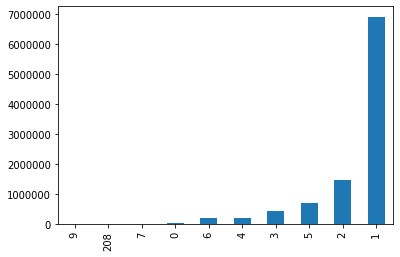

In [51]:
new_train.passenger_count.value_counts(ascending=True).plot.bar()

<span style='color:blue'>1. Passenger count more than 6 seems to be a number occuring very less or an outlier and hence can be removed.</span>

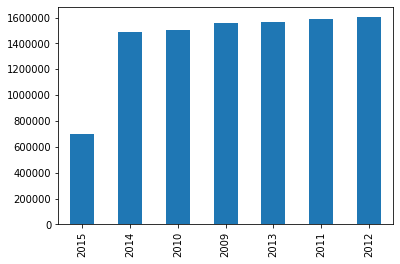

In [52]:
new_train.year.value_counts(ascending=True).plot.bar()

<span style='color:blue'>2. Year attribute has a good distribution.</span>

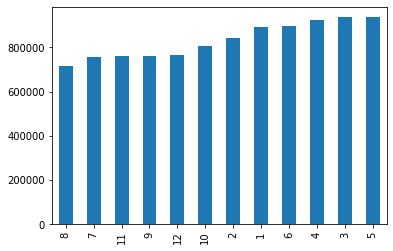

In [53]:
new_train.month.value_counts(ascending=True).plot.bar()

<span style='color:blue'>3. Month attribute has a good distribution.</span>

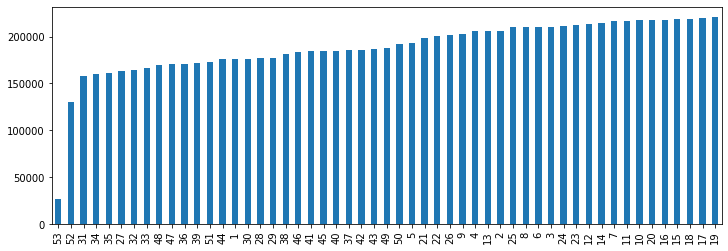

In [54]:
new_train.week.value_counts(ascending=True).plot.bar(figsize=(12,4))

<span style='color:blue'>4. Week attribute has a good distribution.</span>

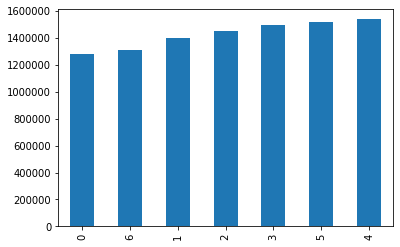

In [55]:
new_train.weekday.value_counts(ascending=True).plot.bar()

<span style='color:blue'>5. Weekday attribute has a good distribution.</span>

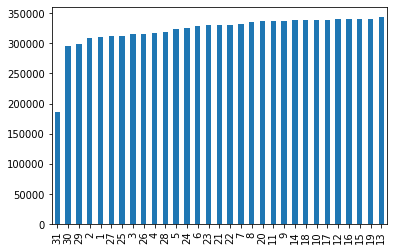

In [56]:
new_train.day.value_counts(ascending=True).plot.bar()

<span style='color:blue'>6. Day attribute has a good distribution.</span>

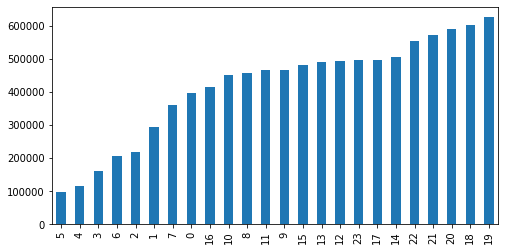

In [57]:
new_train.hour.value_counts(ascending=True).plot.bar(figsize=(8,4))

<span style='color:blue'>7. Hour attribute has a good distribution.</span>

### **Removing the outliers from the data.**

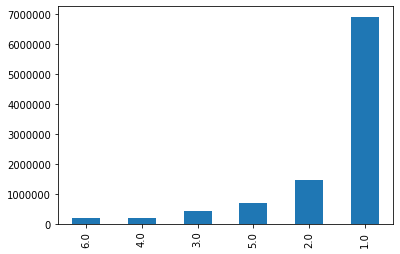

In [58]:
# Removing the passenger counts <1 and >6.
# Reason: <1 passenger does not make sense and >6 passesngers are rare in the dataset and seems to be a very large number for a cab and hence seems to be outliers.
new_train.passenger_count = new_train.passenger_count[new_train.passenger_count.between(left=1, right=6)]
new_train.passenger_count.value_counts(ascending=True).plot.bar()

In [59]:
new_train.isna().sum()

key                      0
fare_amount              0
pickup_datetime          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
passenger_count      35035
distance                 0
year                     0
month                    0
week                     0
weekday                  0
day                      0
hour                     0
dtype: int64

In [60]:
new_train.passenger_count.unique()

array([ 1.,  2.,  4.,  5.,  6.,  3., nan])

In [61]:
new_train.fare_amount.describe()

count    1.000000e+07
mean     1.130970e+01
std      9.619489e+00
min     -9.500000e+01
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.000000e+02
Name: fare_amount, dtype: float64

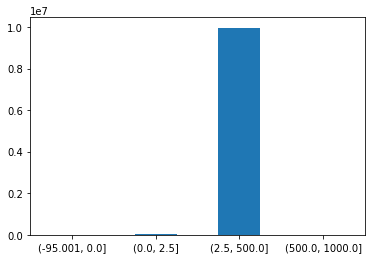

In [62]:
out = pd.cut(new_train.fare_amount, bins=[new_train.fare_amount.min(), 0, 2.5, 500, 1000], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, figsize=(6,4))
plt.show()

In [63]:
new_train.fare_amount = new_train.fare_amount[new_train.fare_amount.between(left=1, right=500)]

In [64]:
new_train.isna().sum()

key                      0
fare_amount            680
pickup_datetime          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
passenger_count      35035
distance                 0
year                     0
month                    0
week                     0
weekday                  0
day                      0
hour                     0
dtype: int64

In [65]:
new_train.distance.describe()

count    1.000000e+07
mean     3.323207e+00
std      3.745759e+00
min      0.000000e+00
25%      1.259000e+00
50%      2.149000e+00
75%      3.906000e+00
max      1.156180e+02
Name: distance, dtype: float64

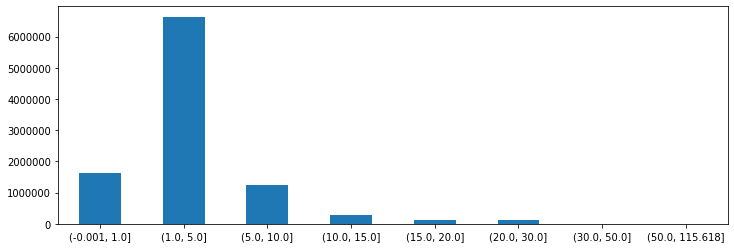

In [66]:
out = pd.cut(new_train.distance, bins=[new_train.distance.min(), 1, 5, 10, 15, 20, 30, 50, new_train.distance.max()], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, figsize=(12,4))
plt.show()

In [67]:
new_train.distance = new_train.distance[new_train.distance.between(left=1, right=30)]

In [68]:
new_train.isna().sum()

key                        0
fare_amount              680
pickup_datetime            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
passenger_count        35035
distance             1618438
year                       0
month                      0
week                       0
weekday                    0
day                        0
hour                       0
dtype: int64

#### **This function was supposed to be used but didnt work out well in the experiment. The code reference is from one of my undergrad basic projects.**

In [69]:
# def detect_outliers(df, n, features):
#     outlier_indices = []
    
#     # iterate ovemaxeatures(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(df[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(df[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
        
#         # outlier step
#         outlier_step = 1.5 * IQR
        
#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
#         # append the found outlier indices for col to the list of outlier indices 
#         outlier_indices.extend(outlier_list_col)
        
#     # select observations containing more than n outliers
#     outlier_indices = Counter(outlier_indices)        
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
#     return multiple_outliers

In [70]:
# Outliers_to_drop = detect_outliers(train, 1, ['distance', 'fare_amount'])
# len(Outliers_to_drop)
# new_train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [71]:
new_train.dropna(inplace=True)

In [73]:
new_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00+00:00,-73.777,40.645,-73.984,40.757,1.0,21.438,2014,1,4,5,25,23
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00+00:00,-74.002,40.730,-73.992,40.725,2.0,1.010,2012,1,2,6,15,18
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00+00:00,-73.995,40.726,-74.011,40.729,1.0,1.389,2013,12,51,1,17,15
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30+00:00,-73.978,40.746,-74.010,40.721,1.0,3.873,2009,6,26,4,26,5
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59+00:00,-74.004,40.720,-74.015,40.709,1.0,1.535,2012,7,30,5,28,2


In [74]:
# new_train.to_csv('train_sub_preprocessed.csv', index=False)

In [75]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973,40.764,-73.981,40.744,1,2.324,2015,1,5,1,27,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.987,40.719,-73.999,40.739,1,2.443,2015,1,5,1,27,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.983,40.751,-73.980,40.746,1,0.611,2011,10,40,5,8,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981,40.768,-73.990,40.752,1,1.934,2012,12,48,5,1,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966,40.790,-73.989,40.744,1,5.469,2012,12,48,5,1,21


In [156]:
# test.to_csv('test_preprocessed.csv', index=False)

In [2]:
new_train = pd.read_csv('train_sub_preprocessed.csv')
new_test = pd.read_csv('test_preprocessed.csv')

In [3]:
new_train.shape, new_test.shape

((8352383, 15), (9914, 14))

In [4]:
new_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2014-01-25 23:30:00.000000294,57.33,2014-01-25 23:30:00+00:00,-73.777,40.645,-73.984,40.757,1.0,21.438,2014,1,4,5,25,23
1,2012-01-15 18:48:00.00000024,4.50,2012-01-15 18:48:00+00:00,-74.002,40.730,-73.992,40.725,2.0,1.010,2012,1,2,6,15,18
2,2013-12-17 15:08:00.0000008,7.00,2013-12-17 15:08:00+00:00,-73.995,40.726,-74.011,40.729,1.0,1.389,2013,12,51,1,17,15
3,2009-06-26 05:59:30.0000002,10.10,2009-06-26 05:59:30+00:00,-73.978,40.746,-74.010,40.721,1.0,3.873,2009,6,26,4,26,5
4,2012-07-28 02:36:59.0000003,8.90,2012-07-28 02:36:59+00:00,-74.004,40.720,-74.015,40.709,1.0,1.535,2012,7,30,5,28,2


In [5]:
new_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973,40.764,-73.981,40.744,1,2.324,2015,1,5,1,27,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.987,40.719,-73.999,40.739,1,2.443,2015,1,5,1,27,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.983,40.751,-73.980,40.746,1,0.611,2011,10,40,5,8,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981,40.768,-73.990,40.752,1,1.934,2012,12,48,5,1,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966,40.790,-73.989,40.744,1,5.469,2012,12,48,5,1,21


In [6]:
new_train.drop(['key', 'pickup_datetime'], axis=1, inplace=True)

In [7]:
new_test.drop(['pickup_datetime'], axis=1, inplace=True)

In [8]:
new_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,57.33,-73.777,40.645,-73.984,40.757,1.0,21.438,2014,1,4,5,25,23
1,4.50,-74.002,40.730,-73.992,40.725,2.0,1.010,2012,1,2,6,15,18
2,7.00,-73.995,40.726,-74.011,40.729,1.0,1.389,2013,12,51,1,17,15
3,10.10,-73.978,40.746,-74.010,40.721,1.0,3.873,2009,6,26,4,26,5
4,8.90,-74.004,40.720,-74.015,40.709,1.0,1.535,2012,7,30,5,28,2


In [9]:
new_test.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,week,weekday,day,hour
0,2015-01-27 13:08:24.0000002,-73.973,40.764,-73.981,40.744,1,2.324,2015,1,5,1,27,13
1,2015-01-27 13:08:24.0000003,-73.987,40.719,-73.999,40.739,1,2.443,2015,1,5,1,27,13
2,2011-10-08 11:53:44.0000002,-73.983,40.751,-73.980,40.746,1,0.611,2011,10,40,5,8,11
3,2012-12-01 21:12:12.0000002,-73.981,40.768,-73.990,40.752,1,1.934,2012,12,48,5,1,21
4,2012-12-01 21:12:12.0000003,-73.966,40.790,-73.989,40.744,1,5.469,2012,12,48,5,1,21


In [10]:
new_train.shape, new_test.shape

((8352383, 13), (9914, 13))

In [11]:
X_train, y_train, X_test = new_train.iloc[:, 1:], new_train.fare_amount, new_test.iloc[:, 1:]

### **Training the various models to generate submission file for the problem.**

In [15]:
lr = LinearRegression(n_jobs=-1)
rg = Ridge(random_state=999)
rfr = RandomForestRegressor(n_jobs=-1, random_state=999)
gbr = GradientBoostingRegressor(random_state=999)
xgb = XGBRegressor(n_jobs=-1, random_state=999)
rfr2 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=999)

In [16]:
lr.fit(X_train, y_train)
fare_amount = pd.Series(lr.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_lr.csv', index=False)

In [17]:
rg.fit(X_train, y_train)
fare_amount = pd.Series(rg.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rg.csv', index=False)

In [18]:
rfr.fit(X_train, y_train)
fare_amount = pd.Series(rfr.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr.csv', index=False)

In [19]:
xgb.fit(X_train, y_train)
fare_amount = pd.Series(xgb.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_xgb.csv', index=False)

In [20]:
gbr.fit(X_train, y_train)
fare_amount = pd.Series(gbr.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_gbr.csv', index=False)

In [21]:
rfr2.fit(X_train, y_train)
fare_amount = pd.Series(rfr2.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr2.csv', index=False)

In [12]:
X_train.shape, y_train.shape, X_test.shape

((8352383, 12), (8352383,), (9914, 12))

In [18]:
params = {'max_depth': [5,7,9], 'n_estimators': [50, 100, 150], 'max_features': ['sqrt', 'log2']}
gs = GridSearchCV(estimator = RandomForestRegressor(n_jobs=30), param_grid = params, scoring = 'neg_mean_squared_error', n_jobs=2, cv = 5)
gs = gs.fit(X_train, y_train)
best_score = gs.best_score_
best_params = gs.best_params_

/home/cs20mtech01004/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [19]:
rfr3 = RandomForestRegressor(n_estimators=50, max_depth=5, max_features='sqrt', n_jobs=-1, random_state=999)
rfr3.fit(X_train, y_train)
fare_amount = pd.Series(rfr3.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr3.csv', index=False)

In [20]:
rfr4 = RandomForestRegressor(n_estimators=50, max_depth=10, max_features='sqrt', n_jobs=-1, random_state=999)
rfr4.fit(X_train, y_train)
fare_amount = pd.Series(rfr4.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr4.csv', index=False)

In [22]:
rfr5 = RandomForestRegressor(n_estimators=50, max_depth=15, max_features='sqrt', n_jobs=-1, random_state=999)
rfr5.fit(X_train, y_train)
fare_amount = pd.Series(rfr5.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr5.csv', index=False)

In [26]:
rfr6 = RandomForestRegressor(n_estimators=50, max_depth=15, max_features='log2', n_jobs=-1, random_state=999)
rfr6.fit(X_train, y_train)
fare_amount = pd.Series(rfr6.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr6.csv', index=False)

In [27]:
rfr7 = RandomForestRegressor(n_estimators=50, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=999)
rfr7.fit(X_train, y_train)
fare_amount = pd.Series(rfr7.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr7.csv', index=False)

In [28]:
rfr8 = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=999)
rfr8.fit(X_train, y_train)
fare_amount = pd.Series(rfr8.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr8.csv', index=False)

In [30]:
rfr9 = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=999)
rfr9.fit(X_train, y_train)
fare_amount = pd.Series(rfr9.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr9.csv', index=False)

In [31]:
rfr10 = RandomForestRegressor(n_estimators=100, max_depth=50, max_features='sqrt', n_jobs=-1, random_state=999)
rfr10.fit(X_train, y_train)
fare_amount = pd.Series(rfr10.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr10.csv', index=False)

In [ ]:
rfr11 = RandomForestRegressor(n_estimators=150, max_depth=100, max_features='sqrt', n_jobs=-1, random_state=999)
rfr11.fit(X_train, y_train)
fare_amount = pd.Series(rfr11.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr10.csv', index=False)

In [14]:
rfr12 = RandomForestRegressor(n_estimators=100, max_depth=100, max_features='sqrt', n_jobs=-1, random_state=999)
rfr12.fit(X_train, y_train)
fare_amount = pd.Series(rfr12.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr12.csv', index=False)

In [ ]:
rfr13 = RandomForestRegressor(n_estimators=150, max_depth=50, max_features='sqrt', n_jobs=-1, random_state=999)
rfr13.fit(X_train, y_train)
fare_amount = pd.Series(rfr13.predict(X_test))
predictions = pd.concat([new_test['key'], fare_amount], axis = 1)
predictions = predictions.rename(columns = {0: 'fare_amount'})
pd.options.display.float_format = '{:,.2f}'.format
predictions.to_csv('Results_rfr13.csv', index=False)

In [33]:
# def plot_decision_boundaries(X, y, model_class, **model_params):
#     """
#     Function to plot the decision boundaries of a classification model.
#     This uses just the first two columns of the data for fitting 
#     the model as we need to find the predicted value for every point in 
#     scatter plot.
#     Arguments:
#             X: Feature data as a NumPy-type array.
#             y: Label data as a NumPy-type array.
#             model_class: A Scikit-learn ML estimator class 
#             e.g. GaussianNB (imported from sklearn.naive_bayes) or
#             LogisticRegression (imported from sklearn.linear_model)
#             **model_params: Model parameters to be passed on to the ML estimator
    
#     Typical code example:
#             plt.figure()
#             plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
#             plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
#             plt.show()
#     """
#     try:
#         X = np.array(X)
#         y = np.array(y).flatten()
#     except:
#         print("Coercing input data to NumPy arrays failed")
#     # Reduces to the first two columns of data
#     reduced_data = X[:, :2]
#     # Instantiate the model object
#     model = model_class(**model_params)
#     # Fits the model with the reduced data
#     model.fit(reduced_data, y)

#     # Step size of the mesh. Decrease to increase the quality of the VQ.
#     h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

#     # Plot the decision boundary. For that, we will assign a color to each
#     x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
#     y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
#     # Meshgrid creation
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#     # Obtain labels for each point in mesh using the model.
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                          np.arange(y_min, y_max, 0.1))

#     # Predictions to obtain the classification results
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

#     # Plotting
#     plt.contourf(xx, yy, Z, alpha=0.4)
#     plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
#     plt.xlabel("Feature-1",fontsize=15)
#     plt.ylabel("Feature-2",fontsize=15)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     return plt

In [ ]:
# plot_decision_boundaries(rfr, X_train, y_train, )

### **Reportings:**
1. Random forest model with default hyperparameters is the **best model** to yield best results with a score: **3.132 (rfr10.csv)** with **n_estimators=100, max_depth=50, max_features='sqrt'** as hyperparameters.
2. Random forest is also the **second best** performing model and is able to score: **3.144 (rfr12.csv)** with **n_estimators=100, max_depth=100, max_features='sqrt'** as hyperparameters.
3. Other than RF classifier, XGBoost is the second best performing classifier with score **3.344 (xgb.csv)** and default hyperparameters.
3. All the other methods starting from the linear regression model to gradient boosting were not able to capture the decision boundaries so well and hence the results reported were less.
4. The best model i.e, random forest was able to capture well the decision boundaries. As it is an ensemble model based on bagging of decision trees and decision trees itself being very powerful in capturing complex linear decision boundaries, this approach outperformed every other approach there is.